In [ ]:

%pip install langdetect
import requests
import pandas as pd
import os
import time
from langdetect import detect, LangDetectException  # Für Spracherkennung


# OpenLibrary API – Bücher abrufen

def fetch_openlibrary_books(subject, total=2000, step=100):
    """
    Holt bis zu 'total' englische Bücher von der OpenLibrary API für ein Genre.
    """
    books = []
    for offset in range(0, total, step):
        url = f"https://openlibrary.org/subjects/{subject}.json?limit={step}&offset={offset}"
        response = requests.get(url).json()
        for work in response.get("works", []):
            langs = work.get("languages", [])
            if langs and not any("eng" in lang for lang in langs):
                continue  # Nur englische Bücher
            books.append({
                "title": work.get("title", "N/A"),
                "authors": ", ".join([a.get("name", "Unknown") for a in work.get("authors", [])]),
                "published": work.get("first_publish_year", "Unknown"),
                "genre": subject
            })
        time.sleep(0.2)
    return pd.DataFrame(books)


# Google Books API – Beschreibung holen

def get_google_books_description(title, author):
    """
    Holt englische Beschreibung von Google Books und prüft die Sprache.
    """
    query = f"{title} {author}"
    url = "https://www.googleapis.com/books/v1/volumes"
    params = {"q": query, "maxResults": 1, "langRestrict": "en"}
    try:
        response = requests.get(url, params=params, timeout=5).json()
        items = response.get("items", [])
        if items:
            description = items[0].get("volumeInfo", {}).get("description", "No description")
            if description != "No description":
                try:
                    if detect(description) != "en":  # Prüfe, ob die Sprache Englisch ist
                        return "No description"
                except LangDetectException:
                    return "No description"
            return description
        return "No description"
    except:
        return "No description"


# Titel aus Beschreibung entfernen

def clean_description(title, description):
    """
    Entfernt den Titel aus der Beschreibung, falls er am Anfang wiederholt wird.
    """
    description = description.strip()
    if description.lower().startswith(title.lower()):
        return description[len(title):].strip()
    return description


# Mehrere Genres sammeln

genres = ["fantasy", "romance", "science_fiction", "crime", "history", "horror", "cooking"]

all_books = pd.DataFrame()
os.makedirs("data", exist_ok=True)

for g in genres:
    print(f"--> Lade Bücher für Genre: {g}")
    df_genre = fetch_openlibrary_books(g, total=2000)  # 2000 pro Genre
    print(f"   -> Ergänze englische Beschreibungen über Google Books...")
    df_genre["description"] = df_genre.apply(
        lambda row: clean_description(row["title"], get_google_books_description(row["title"], row["authors"])),
        axis=1
    )
    all_books = pd.concat([all_books, df_genre], ignore_index=True)

#Speichern
all_books.to_csv("data/books_data.csv", index=False, encoding="utf-8")
print("Rohdaten gespeichert als 'data/books_data.csv'")


Note: you may need to restart the kernel to use updated packages.
--> Lade Bücher für Genre: fantasy
   -> Ergänze englische Beschreibungen über Google Books...
--> Lade Bücher für Genre: romance
   -> Ergänze englische Beschreibungen über Google Books...
--> Lade Bücher für Genre: science_fiction
   -> Ergänze englische Beschreibungen über Google Books...
--> Lade Bücher für Genre: crime
   -> Ergänze englische Beschreibungen über Google Books...
--> Lade Bücher für Genre: history
   -> Ergänze englische Beschreibungen über Google Books...
--> Lade Bücher für Genre: horror
   -> Ergänze englische Beschreibungen über Google Books...
--> Lade Bücher für Genre: cooking
   -> Ergänze englische Beschreibungen über Google Books...
Rohdaten gespeichert als 'data/books_data.csv'


In [13]:
import pandas as pd

# CSV-Datei laden
data_path = "data/books_data.csv"
df = pd.read_csv(data_path)

# Erste Zeilen anzeigen
print(df.head())


# Anzahl der Einträge und Spalten
print(f"Datensatz: {len(df)} Bücher, Spalten: {df.columns.tolist()}")


                              title                 authors  published  \
0  Alice's Adventures in Wonderland           Lewis Carroll     1865.0   
1        The Wonderful Wizard of Oz           L. Frank Baum     1899.0   
2                   Treasure Island  Robert Louis Stevenson     1880.0   
3                Gulliver's Travels          Jonathan Swift     1726.0   
4                        The Prince     Niccolò Machiavelli     1515.0   

     genre     description  
0  fantasy  No description  
1  fantasy  No description  
2  fantasy  No description  
3  fantasy  No description  
4  fantasy  No description  
Datensatz: 14000 Bücher, Spalten: ['title', 'authors', 'published', 'genre', 'description']


In [ ]:

# Data Preparation

import pandas as pd

# Falls all_books nicht existiert, lade die Daten aus der CSV-Datei
try:
    all_books
except NameError:
    all_books = pd.read_csv("data/books_data.csv")

print(f"Vorher: {len(all_books)} Bücher.")
all_books = all_books[all_books["description"].notnull()]  #  NaN entfernen
all_books = all_books[all_books["description"] != "No description"]  # "No description" entfernen
print(f"Nachher: {len(all_books)} Bücher mit gültiger Beschreibung.")


# Titel + Beschreibung kombinieren

all_books["text"] = all_books["title"].fillna('') + " " + all_books["description"].fillna('')

# Duplikate entfernen
before = len(all_books)
all_books = all_books.drop_duplicates(subset=["text"], keep="first").reset_index(drop=True)
after = len(all_books)
print(f"Duplikate entfernt: {before - after} Einträge gelöscht.")


# Textbereinigung

import re
import string

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(rf"[{string.punctuation}]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

all_books["text"] = all_books["text"].apply(clean_text)


# Zielvariable encoden

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
all_books["label"] = label_encoder.fit_transform(all_books["genre"])
print("\nGenres:", list(label_encoder.classes_))


# Speichern

output_file = "data/clean_books.csv"
all_books.to_csv(output_file, index=False)
print(f"\nBereinigter Datensatz gespeichert als '{output_file}'.")
print(all_books.head(10))


Vorher: 14000 Bücher.
Nachher: 6730 Bücher mit gültiger Beschreibung.
Duplikate entfernt: 195 Einträge gelöscht.

Genres: ['cooking', 'crime', 'fantasy', 'history', 'horror', 'romance', 'science_fiction']

Bereinigter Datensatz gespeichert als 'data/clean_books.csv'.
                         title  \
0    Through the Looking-Glass   
1          Wind in the Willows   
2    A Midsummer Night's Dream   
3      The Lost Princess of Oz   
4      The Story of the Amulet   
5               The Road to Oz   
6              The Sea Fairies   
7  Baum's American Fairy Tales   
8                   Sky Island   
9     The Patchwork Girl of Oz   

                                             authors  published    genre  \
0  Lewis Carroll, Lewis Carroll, Lewis Lewis Carroll     1865.0  fantasy   
1  Kenneth Grahame, Michael Hague, John Burningha...     1908.0  fantasy   
2                                William Shakespeare     1600.0  fantasy   
3                                      L. Frank Baum 

In [16]:
import pandas as pd

# Datensatz laden
df = pd.read_csv("data/clean_books.csv")

# Anzahl der Bücher pro Genre
genre_counts = df["genre"].value_counts()

print("Anzahl der Bücher pro Genre:")
print(genre_counts)


Anzahl der Bücher pro Genre:
genre
cooking            1323
crime              1141
horror              990
romance             952
fantasy             766
science_fiction     741
history             622
Name: count, dtype: int64


Note: you may need to restart the kernel to use updated packages.


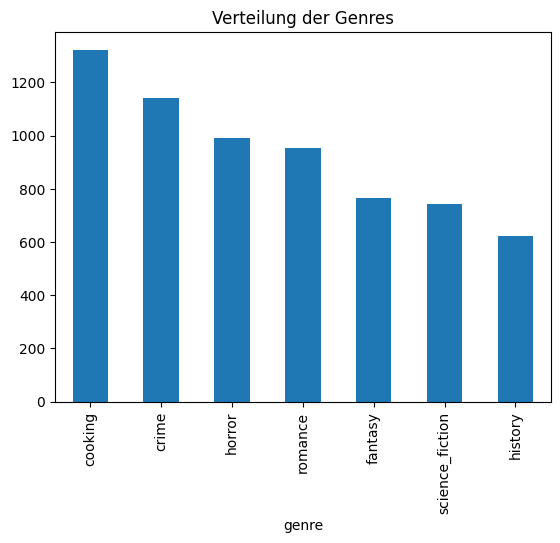

In [17]:
%pip install matplotlib
import matplotlib.pyplot as plt
df["genre"].value_counts().plot(kind="bar")
plt.title("Verteilung der Genres")
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import pickle


df = pd.read_csv("data/clean_books.csv")
X = df["text"]
y = df["genre"]


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# TF-IDF Vektorisierung
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# Oversampling 
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_tfidf, y_train)
print(f"Vor Oversampling:  {dict(pd.Series(y_train).value_counts())}")
print(f"Nach Oversampling: {dict(pd.Series(y_train_res).value_counts())}\n")

# Dummy Baseline
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_res, y_train_res)
y_dummy = dummy.predict(X_test_tfidf)
print("---- Dummy Baseline ----")
print("Accuracy (Dummy):", accuracy_score(y_test, y_dummy), "\n")

# Modelle zum Vergleich
models = {
    "LogisticRegression": LogisticRegression(max_iter=300),
    "MultinomialNB":      MultinomialNB(),
    "RandomForest":       RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, clf in models.items():

    clf.fit(X_train_res, y_train_res)
    y_pred = clf.predict(X_test_tfidf)
    print(f"==== {name} ====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("-" * 50)

# Hauptmodell speichern
best_model = models["LogisticRegression"]
with open("model.pkl", "wb") as f:
    pickle.dump(best_model, f)
with open("tfidf.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("\nModelle und Vektorisierer gespeichert!")


Vor Oversampling:  {0: 1058, 1: 913, 4: 792, 5: 762, 2: 613, 6: 593, 3: 497}
Nach Oversampling: {1: 1058, 5: 1058, 3: 1058, 0: 1058, 4: 1058, 6: 1058, 2: 1058}

---- Dummy Baseline ----
Accuracy (Dummy): 0.20275439938791126 

==== LogisticRegression ====
Accuracy: 0.7689364957918898
                 precision    recall  f1-score   support

        cooking       0.96      0.86      0.91       265
          crime       0.88      0.76      0.82       228
        fantasy       0.67      0.74      0.70       153
        history       0.58      0.77      0.66       125
         horror       0.74      0.73      0.74       198
        romance       0.71      0.82      0.76       190
science_fiction       0.75      0.64      0.69       148

       accuracy                           0.77      1307
      macro avg       0.76      0.76      0.75      1307
   weighted avg       0.78      0.77      0.77      1307

--------------------------------------------------
==== MultinomialNB ====
Accuracy: 0

In [22]:

# Vorhersagefunktion

def predict_genre(title, description):
    text = clean_text(title + " " + description)
    text_tfidf = tfidf.transform([text])  # Text in TF-IDF umwandeln
    pred = model.predict(text_tfidf)[0]   # Modellvorhersage
    return label_encoder.inverse_transform([pred])[0]


# Mehrere Beispielvorhersagen

examples = [
    { "title": "Love in Paris","description": "A touching story of two strangers falling in love in the heart of Paris." },
    {"title": "The Haunted Mansion","description": "A group of friends experiences terrifying events in an abandoned house."},
    {"title": "The Secret War", "description": "A historical narrative about soldiers in World War II and their struggles."},
    {"title": "Spaceship to Mars", "description": "A team of astronauts sets out on a dangerous mission to colonize Mars."},
    {"title": "Mystery in the Woods", "description": "Detectives investigate a series of strange disappearances in a small village."},
    {"title": "Harry Potter and the Philosopher's Stone", "description": "A young boy discovers he is a wizard and attends a magical school."},
    {"title": "The Shining", "description": "A family stays at an isolated hotel haunted by supernatural forces."},
    {"title": "Dune", "description": "A young man becomes a messiah on a desert planet fighting for control of spice."},
    {"title": "The Hobbit", "description": "A hobbit embarks on an adventure with dwarves to reclaim a lost kingdom."},
    {"title": "The Girl with the Dragon Tattoo", "description": "A journalist and hacker investigate a decades-old family mystery."},
    {"title": "The Martian", "description": "An astronaut is stranded on Mars and must survive using science and ingenuity."}
]

print("\nBeispielvorhersagen:")
for example in examples:
    genre_prediction = predict_genre(example["title"], example["description"])
    print(f"Title: {example['title']}")
    print(f"Predicted Genre: {genre_prediction}")
    print("-" * 50)



Beispielvorhersagen:
Title: Love in Paris
Predicted Genre: romance
--------------------------------------------------
Title: The Haunted Mansion
Predicted Genre: horror
--------------------------------------------------
Title: The Secret War
Predicted Genre: history
--------------------------------------------------
Title: Spaceship to Mars
Predicted Genre: science_fiction
--------------------------------------------------
Title: Mystery in the Woods
Predicted Genre: horror
--------------------------------------------------
Title: Harry Potter and the Philosopher's Stone
Predicted Genre: fantasy
--------------------------------------------------
Title: The Shining
Predicted Genre: horror
--------------------------------------------------
Title: Dune
Predicted Genre: science_fiction
--------------------------------------------------
Title: The Hobbit
Predicted Genre: fantasy
--------------------------------------------------
Title: The Girl with the Dragon Tattoo
Predicted Genre: fanta